In [38]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; } </style>"))
display(HTML("<style>div.cell.selected {border-left-width: 0px !important;} </style>"))

In [39]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import pandas as pd

import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt

import random
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score , precision_score , recall_score ,silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Softmax,Dropout
from tensorflow.keras.layers import LSTM,Flatten
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder

import math
import uuid
import random
import zipfile

! pip -q install phe
from phe import paillier



In [40]:
def split(data,test_size):
    X_train, X_val, ytrain, yval = train_test_split(data[0], data[1],test_size = 0.2,shuffle=False)
    y_train =to_categorical(ytrain)
    y_val=to_categorical(yval)
    return X_train, X_val, y_train, y_val

In [41]:
def one_hot(df,column):
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder_df = pd.DataFrame(encoder.fit_transform(df[column]).toarray())
    final_df = df.join(encoder_df)
    final_df = final_df.drop(column,axis=1)
    return final_df

In [42]:
def create_local_clients( num_clients,initial='local_client'):
   
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    data=[]
    for i in range(num_clients):
        temp=pd.read_csv(r"C:\Users\sagar\Downloads\Processed_data_client"+'{}'.format(i+1)+".csv")
        temp=temp.sample(frac = 1)
        temp=temp.sample(frac = 1) 
        label=temp[['Category']].copy()
        #label=one_hot(label_temp,['Category'])
        temp=temp[['EC','VWC','DP','temp']].copy()
        
        
        data.append((temp,label))
        
    shards = [data[i] for i in range(0, num_clients)]

    return {client_names[i] : shards[i] for i in range(len(client_names))}

num_local_clients=7
local_client_initial='local_client'
local_client_names = ['{}_{}'.format(local_client_initial, i+1) for i in range(num_local_clients)]
local_clients=create_local_clients(num_local_clients,local_client_initial)

train_test_local_clients=[]
for i in local_client_names:
    ret = split(local_clients[i],0.2)  
    train_test_local_clients.append(ret)

In [43]:
def create_global_clients(num_clients,initial='global_client'):
   
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    data=[]
    for i in range(num_clients):
        temp=pd.read_csv(r"C:\Users\sagar\OneDrive\Desktop\data_soil_downloads\all_weighted_classified_"+'{}'.format(i+1)+".csv")
        temp=temp.sample(frac = 1)
        temp=temp.sample(frac = 1)
        label=temp[['Category']].copy()
        #label=one_hot(label_temp,['Category'])
        temp=temp[['SDTO', 'STPC', 'CLPC', 'BULK', 'ORGC', 'TOTN', 'CECS', 'BSAT', 'PHAQ',
       'TCEQ', 'ELCO', 'VWC', 'DP', 'Temp']].copy()
        data.append((temp,label))
        
    shards = [data[i] for i in range(0, num_clients)]

    return {client_names[i] : shards[i] for i in range(len(client_names))}

num_global_clients=1
global_client_initial='Global_client'
global_client_names = ['{}_{}'.format(global_client_initial, i+1) for i in range(num_global_clients)]
global_clients=create_global_clients(num_global_clients,global_client_initial)

train_test_global_clients=[]
for i in global_client_names:
    ret = split(global_clients[i],0.2)  
    train_test_global_clients.append(ret)
ret2=split(global_clients[i],0.2)

In [44]:
np.shape(train_test_local_clients[0][3])

(220, 4)

In [45]:
class Model_alpha:
    def build_global_model(self):
        normalizer = preprocessing.Normalization()
        model = tf.keras.Sequential()
        #model.add(normalizer)
        model.add(Dense(24,activation='relu',input_shape=(14,)))
        #model.add(Dropout(0.2))
        model.add(Dense(4))
        model.add(Activation("softmax"))
        return model
    def build_local_model(self):
        normalizer = preprocessing.Normalization()
        model = tf.keras.Sequential()
        #model.add(normalizer)
        model.add(Dense(24,activation='relu',input_shape=(4,)))
        #model.add(Dropout(0.2))
        model.add(Dense(4))
        model.add(Activation("softmax"))
        return model

lr = 1e-3

loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer=keras.optimizers.Adam(learning_rate=lr)
#optimizer=tf.keras.optimizers.SGD(learning_rate=lr)
#optimizer = SGD(learning_rate=lr,decay=lr / comms_round,momentum=0.9)  

# optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
# loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# train_acc_metric = tf.keras.metrics.CategoricalAccuracy()

In [37]:
def scale_model_weights(weight, scalar):
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def Averaging_weights(length,layer1,gl1_w,gl1_b):
#     res_final=[]
    
#     to_avg_l3=[]
    to_avg_l1=[]
    bias_l1=[]
#     bias_l3=[]
    
    #gl1_w = gl1[0]
    #gl1_b =gl1[1]
    gl1_w1 = gl1_w[:-4]
    gl1_w2 = gl1_w[-4:]
    
    for i in range(length):
        to_avg_l1.append(layer1[i][0])
#         to_avg_l3.append(layer3[i][0])
        bias_l1.append(layer1[i][1])
#         bias_l3.append(layer3[i][1])
       
    x=0
    lwl1= np.array(to_avg_l1[0],dtype=object)
    lbl1=np.array(bias_l1[0],dtype=object)
#     lwl3= np.array(to_avg_l3[0],dtype=object)
#     lbl3=np.array(bias_l3[0],dtype=object)
    
    for i in range(1,length):
        lwl1 = np.add(lwl1,np.array(to_avg_l1[i]))
        lbl1 = np.add(lbl1,np.array(bias_l1[i]))
#         lwl3 = np.add(lwl3,np.array(to_avg_l3[i]))
#         lbl3 = np.add(lbl3,np.array(bias_l3[i]))
     #average of weights of commom attrrbutes of global and local clients' models 
    lwl1 = np.add(lwl1,np.array(gl1_w2,dtype=object))
    lwl1 = lwl1/(len(to_avg_l1)+1)
    lbl1 = lbl1/len(bias_l1)
#     lwl3 = lwl3/len(to_avg_l3)
#     lbl3 = lbl3/len(bias_l3)
    
    #preparation for global model
    lwl1=lwl1.tolist()
    gl1_w1=gl1_w1.tolist()
    gl1_w1_w2 =gl1_w1 + lwl1
    gl1_w1_w2=np.array(gl1_w1_w2)
    
    global_model_weights = []
    global_model_weights.append(gl1_w1_w2)
    global_model_weights.append(gl1_b)
    
    local_model_weights=[]
    local_model_weights.append(np.array(lwl1))
    local_model_weights.append(lbl1)
    
    #local_model_weights.append(lwl3)
    #local_model_weights.append(lbl3)
#     res_final.append(gl1_w1_w2)
#     res_final.append(lbl1)
#     res_final.append(lwl3)
#     res_final.append(lbl3)
    return global_model_weights , local_model_weights


def test_model_global(X_test, Y_test,  model, comm_round,client):
    lossfn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    output = model.predict(X_test)
    loss = lossfn(Y_test, output)
    acc = accuracy_score(np.argmax(Y_test,axis=1), np.argmax(output, axis=1))
    precision = precision_score(np.argmax(Y_test,axis=1), np.argmax(output, axis=1),average=None)
    recall=recall_score(np.argmax(Y_test,axis=1), np.argmax(output, axis=1),average=None)
    F1_Score = 2 * (precision * recall) / (precision + recall)
    print('comm_round: {} | client_name: {} | global_acc: {:.4%} | global_loss: {} | precision: {} | recall: {} | F1: {}'.format(comm_round,client, acc, loss, precision ,recall , F1_Score))
    return acc, loss 

def test_model_local(X_test, Y_test,  model, comm_round,client):
    lossfn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    output = model.predict(X_test)
    loss = lossfn(Y_test, output)
    acc = accuracy_score(np.argmax(Y_test,axis=1), np.argmax(output, axis=1))
    precision = precision_score(np.argmax(Y_test,axis=1), np.argmax(output, axis=1),average=None)
    recall=recall_score(np.argmax(Y_test,axis=1), np.argmax(output, axis=1),average=None)
    F1_Score = 2 * (precision * recall) / (precision + recall)
    print('comm_round: {} | client_name: {} | local_acc: {:.4%} | local_loss: {} | precision: {} | recall: {} | F1: {}'.format(comm_round,client, acc, loss, precision, recall , F1_Score))
    return acc, loss 

In [10]:
#initialize global model
model_global = Model_alpha()
global_model = model_global.build_global_model()
global_model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
global_history=global_model.fit(train_test_global_clients[0][0],train_test_global_clients[0][2], epochs=400, verbose=1)

In [11]:
fig1=plt.figure()
plt.plot(global_history.history['loss'])
plt.title('model train vs  loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
fig2=plt.figure()
plt.plot(global_history.history['accuracy'])
plt.title('model train vs  accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

NameError: name 'global_history' is not defined

<Figure size 432x288 with 0 Axes>

comm_round: -1 | client_name: local_client_1 | local_acc: 93.1818% | local_loss: 0.9291449785232544 | precision: [1.    1.    0.939 0.857] | recall: [0.857 0.696 0.975 0.909] | F1: [0.923 0.821 0.956 0.882]


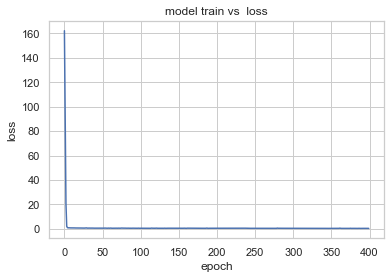

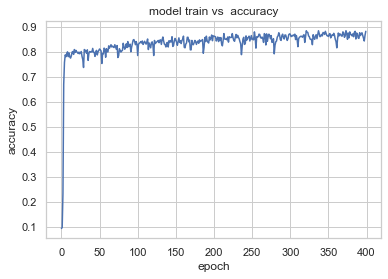

comm_round: -1 | client_name: local_client_2 | local_acc: 92.5134% | local_loss: 0.8765331506729126 | precision: [0.938 0.897 0.979] | recall: [0.938 0.97  0.839] | F1: [0.938 0.932 0.904]


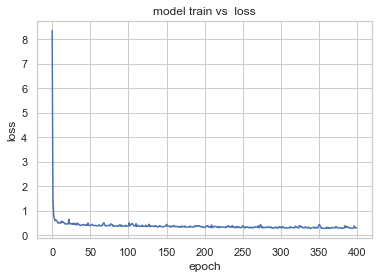

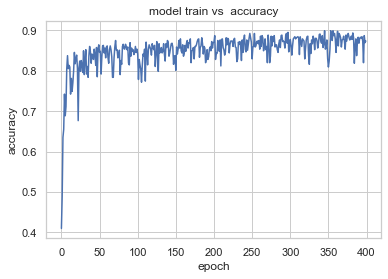

comm_round: -1 | client_name: local_client_3 | local_acc: 84.5745% | local_loss: 1.0192266702651978 | precision: [1.    0.763 0.958 1.   ] | recall: [1.    1.    0.639 0.889] | F1: [1.    0.866 0.767 0.941]


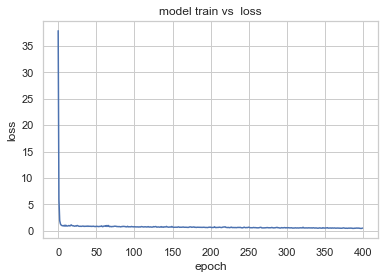

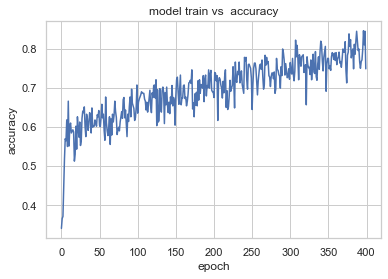

comm_round: -1 | client_name: local_client_4 | local_acc: 82.0106% | local_loss: 1.0408939123153687 | precision: [0.    0.714 0.875 0.792] | recall: [0.    0.769 0.808 0.847] | F1: [  nan 0.741 0.84  0.819]


C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


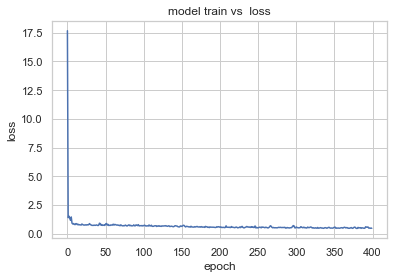

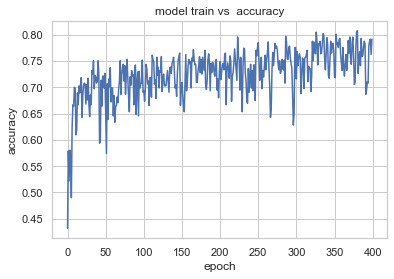

comm_round: -1 | client_name: local_client_5 | local_acc: 88.9474% | local_loss: 0.8967311382293701 | precision: [0.    0.905 0.866 0.922] | recall: [0.    0.884 0.933 0.839] | F1: [  nan 0.894 0.898 0.879]


C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


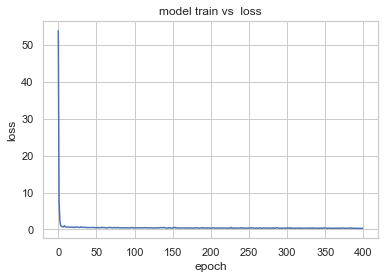

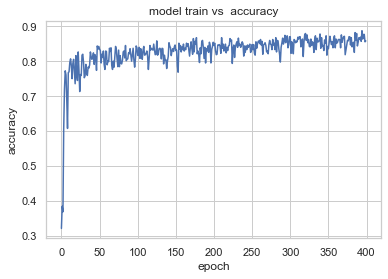

comm_round: -1 | client_name: local_client_6 | local_acc: 78.1726% | local_loss: 1.0230897665023804 | precision: [0.957 0.732 1.   ] | recall: [0.88  0.991 0.304] | F1: [0.917 0.842 0.466]


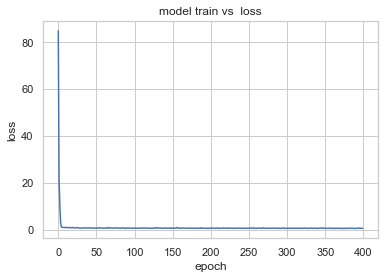

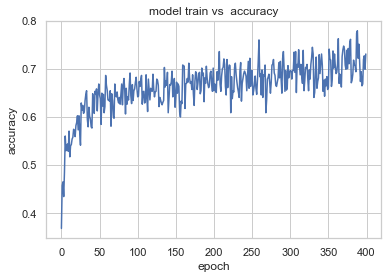

comm_round: -1 | client_name: local_client_7 | local_acc: 73.7113% | local_loss: 0.9661092758178711 | precision: [0.958 1.    0.658] | recall: [1.   0.32 1.  ] | F1: [0.979 0.485 0.793]


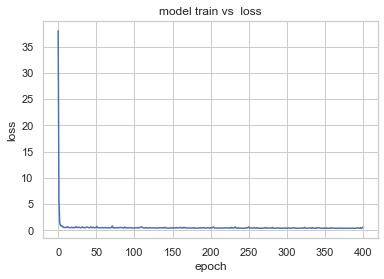

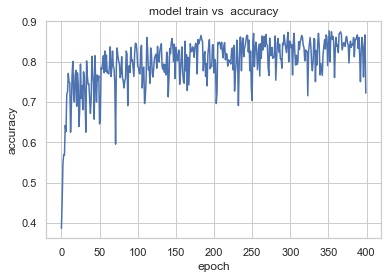

In [36]:
client_names= list(local_clients.keys())
for i,client in enumerate(client_names):
    model_local = Model_alpha()
    local_model = model_local.build_local_model()
    local_model.compile(loss=loss, 
                optimizer=optimizer, 
                metrics=metrics)
        
    #fit local model with client's data
    comm_round = -1
    local_history=local_model.fit(train_test_local_clients[i][0],train_test_local_clients[i][2], epochs=400, verbose=0)
    local_acc, local_loss = test_model_local(train_test_local_clients[i][1], train_test_local_clients[i][3],local_model, comm_round,client)
    fig1=plt.figure()
    plt.plot(local_history.history['loss'])
    plt.title('model train vs  loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    fig2=plt.figure()
    plt.plot(local_history.history['accuracy'])
    plt.title('model train vs  accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()

In [12]:

# global_layer1_weight  = global_model.layers[0].get_weights()[0]
# global_layer1_bias=global_model.layers[0].get_weights()[1]
# global_weight_layer_1=[]
# global_weight_layer_1.append(global_layer1_weight[-4:])
# global_weight_layer_1.append(global_layer1_bias)
# K.clear_session()

In [13]:
comms_round = 200
for comm_round in range(comms_round):
    print(comm_round)
    if comm_round>0:
        global_model.layers[0].set_weights(global_weights_new)
    global_model.fit(train_test_global_clients[0][0], train_test_global_clients[0][2],epochs=30, verbose=0)
    # get the global model's weights 
    global_layer1_weight  = global_model.layers[0].get_weights()[0]
    global_layer1_bias=global_model.layers[0].get_weights()[1]
    global_weight_layer_1=[]
    global_weight_layer_1.append(global_layer1_weight[-4:])
    global_weight_layer_1.append(global_layer1_bias)
        #global_weights_2 = np.array(global_model.layers[2].get_weights(),dtype=object)
    local_weight_list_layer1 = []
    local_weight_list_layer3 = []

    #randomize client data - using keys
    client_names= list(local_clients.keys())
    
    #loop through each client and create new local model
    for i,client in enumerate(client_names):
        model_local = Model_alpha()
        local_model = model_local.build_local_model()
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        if comm_round >0 :
            local_model.layers[0].set_weights(local_weights_new)
        #set local model weight to the weight of the global model
        #ex=local_model.get_weights()
        #local_model.layers[0].set_weights(global_weight_layer_1)
        #local_model.layers[2].set_weights(global_weights_2)
        
        #fit local model with client's data
        local_model.fit(train_test_local_clients[i][0],train_test_local_clients[i][2], epochs=30, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = 1 #0.3
        scaled_weights_layer1 = scale_model_weights(np.array(local_model.layers[0].get_weights(),dtype=object), scaling_factor)
        local_weight_list_layer1.append(scaled_weights_layer1)
#         scaled_weights_layer3 = scale_model_weights(np.array(local_model.layers[2].get_weights(),dtype=object),scaling_factor)
#         local_weight_list_layer3.append(scaled_weights_layer3)

        #clear session to free memory after each communication round
        K.clear_session()
        
    #test global model and print out metrics after each communications round
    avg_local_acc=0
    global_client_names= list(global_clients.keys())
    for i,client in enumerate(global_client_names):
        global_acc, global_loss = test_model_global(train_test_global_clients[i][1], train_test_global_clients[i][3], global_model, comm_round,client)
    local_client_names= list(local_clients.keys())
    for i,client in enumerate(local_client_names):
        local_acc, local_loss = test_model_local(train_test_local_clients[i][1], train_test_local_clients[i][3],local_model, comm_round,client)
        avg_local_acc+=local_acc
    print("Average Local Clients Accuracy : {:.4%}".format(avg_local_acc/7))
    
    #the average over all the local model
    global_weights_new , local_weights_new = Averaging_weights(len(local_client_names),local_weight_list_layer1 , global_layer1_weight , global_layer1_bias)
    
    #update global and local model 
    global_model.layers[0].set_weights(global_weights_new)
    local_model.layers[0].set_weights(local_weights_new)
    
       

0
comm_round: 0 | client_name: Global_client_1 | global_acc: 92.1631% | global_loss: 0.8586364388465881
comm_round: 0 | client_name: local_client_1 | local_acc: 27.8788% | local_loss: 1.3286418914794922
comm_round: 0 | client_name: local_client_2 | local_acc: 60.0000% | local_loss: 1.1869025230407715
comm_round: 0 | client_name: local_client_3 | local_acc: 12.9252% | local_loss: 1.4652410745620728
comm_round: 0 | client_name: local_client_4 | local_acc: 71.7949% | local_loss: 1.1774863004684448
comm_round: 0 | client_name: local_client_5 | local_acc: 57.9310% | local_loss: 1.1819405555725098
comm_round: 0 | client_name: local_client_6 | local_acc: 59.1463% | local_loss: 1.2165530920028687
comm_round: 0 | client_name: local_client_7 | local_acc: 66.2651% | local_loss: 1.1536879539489746
1
comm_round: 1 | client_name: Global_client_1 | global_acc: 94.0071% | global_loss: 0.8341205716133118
comm_round: 1 | client_name: local_client_1 | local_acc: 24.2424% | local_loss: 1.3408282995224
com

comm_round: 10 | client_name: local_client_6 | local_acc: 51.8293% | local_loss: 1.2306922674179077
comm_round: 10 | client_name: local_client_7 | local_acc: 66.8675% | local_loss: 1.1447643041610718
11
comm_round: 11 | client_name: Global_client_1 | global_acc: 97.5887% | global_loss: 0.7829509973526001
comm_round: 11 | client_name: local_client_1 | local_acc: 23.0303% | local_loss: 1.3982479572296143
comm_round: 11 | client_name: local_client_2 | local_acc: 65.1429% | local_loss: 1.121301293373108
comm_round: 11 | client_name: local_client_3 | local_acc: 12.2449% | local_loss: 1.5149458646774292
comm_round: 11 | client_name: local_client_4 | local_acc: 60.8974% | local_loss: 1.1280990839004517
comm_round: 11 | client_name: local_client_5 | local_acc: 70.3448% | local_loss: 1.1123806238174438
comm_round: 11 | client_name: local_client_6 | local_acc: 56.0976% | local_loss: 1.186200737953186
comm_round: 11 | client_name: local_client_7 | local_acc: 80.7229% | local_loss: 1.0683623552322

comm_round: 21 | client_name: Global_client_1 | global_acc: 97.5177% | global_loss: 0.7756593823432922
comm_round: 21 | client_name: local_client_1 | local_acc: 24.2424% | local_loss: 1.3170033693313599
comm_round: 21 | client_name: local_client_2 | local_acc: 55.4286% | local_loss: 1.1542726755142212
comm_round: 21 | client_name: local_client_3 | local_acc: 21.7687% | local_loss: 1.3328900337219238
comm_round: 21 | client_name: local_client_4 | local_acc: 69.8718% | local_loss: 1.0621297359466553
comm_round: 21 | client_name: local_client_5 | local_acc: 56.5517% | local_loss: 1.152227520942688
comm_round: 21 | client_name: local_client_6 | local_acc: 61.5854% | local_loss: 1.1408780813217163
comm_round: 21 | client_name: local_client_7 | local_acc: 71.0843% | local_loss: 1.0919101238250732
22
comm_round: 22 | client_name: Global_client_1 | global_acc: 94.1844% | global_loss: 0.8020317554473877
comm_round: 22 | client_name: local_client_1 | local_acc: 25.4545% | local_loss: 1.403482198

comm_round: 31 | client_name: local_client_5 | local_acc: 64.8276% | local_loss: 1.090440273284912
comm_round: 31 | client_name: local_client_6 | local_acc: 46.3415% | local_loss: 1.2077791690826416
comm_round: 31 | client_name: local_client_7 | local_acc: 77.7108% | local_loss: 0.9981167316436768
32
comm_round: 32 | client_name: Global_client_1 | global_acc: 99.5035% | global_loss: 0.7587786912918091
comm_round: 32 | client_name: local_client_1 | local_acc: 17.5758% | local_loss: 1.4692809581756592
comm_round: 32 | client_name: local_client_2 | local_acc: 61.7143% | local_loss: 1.0996700525283813
comm_round: 32 | client_name: local_client_3 | local_acc: 24.4898% | local_loss: 1.4137226343154907
comm_round: 32 | client_name: local_client_4 | local_acc: 71.7949% | local_loss: 1.0133920907974243
comm_round: 32 | client_name: local_client_5 | local_acc: 71.0345% | local_loss: 1.0529873371124268
comm_round: 32 | client_name: local_client_6 | local_acc: 54.2683% | local_loss: 1.133892059326

comm_round: 42 | client_name: Global_client_1 | global_acc: 99.2908% | global_loss: 0.7565123438835144
comm_round: 42 | client_name: local_client_1 | local_acc: 21.8182% | local_loss: 1.4405637979507446
comm_round: 42 | client_name: local_client_2 | local_acc: 57.7143% | local_loss: 1.1328555345535278
comm_round: 42 | client_name: local_client_3 | local_acc: 10.8844% | local_loss: 1.5008448362350464
comm_round: 42 | client_name: local_client_4 | local_acc: 62.1795% | local_loss: 1.080133318901062
comm_round: 42 | client_name: local_client_5 | local_acc: 66.8966% | local_loss: 1.0932490825653076
comm_round: 42 | client_name: local_client_6 | local_acc: 47.5610% | local_loss: 1.2039916515350342
comm_round: 42 | client_name: local_client_7 | local_acc: 78.9157% | local_loss: 0.9966797232627869
43
comm_round: 43 | client_name: Global_client_1 | global_acc: 98.1206% | global_loss: 0.7670453190803528
comm_round: 43 | client_name: local_client_1 | local_acc: 19.3939% | local_loss: 1.493322014

comm_round: 52 | client_name: local_client_5 | local_acc: 30.3448% | local_loss: 1.3816415071487427
comm_round: 52 | client_name: local_client_6 | local_acc: 39.0244% | local_loss: 1.3667182922363281
comm_round: 52 | client_name: local_client_7 | local_acc: 29.5181% | local_loss: 1.3713566064834595
53
comm_round: 53 | client_name: Global_client_1 | global_acc: 99.5390% | global_loss: 0.7536990642547607
comm_round: 53 | client_name: local_client_1 | local_acc: 20.0000% | local_loss: 1.4416199922561646
comm_round: 53 | client_name: local_client_2 | local_acc: 56.5714% | local_loss: 1.20618736743927
comm_round: 53 | client_name: local_client_3 | local_acc: 8.8435% | local_loss: 1.4556721448898315
comm_round: 53 | client_name: local_client_4 | local_acc: 62.1795% | local_loss: 1.246579647064209
comm_round: 53 | client_name: local_client_5 | local_acc: 64.1379% | local_loss: 1.1585482358932495
comm_round: 53 | client_name: local_client_6 | local_acc: 39.0244% | local_loss: 1.308889627456665

comm_round: 63 | client_name: Global_client_1 | global_acc: 99.5390% | global_loss: 0.7527703642845154
comm_round: 63 | client_name: local_client_1 | local_acc: 21.8182% | local_loss: 1.4324396848678589
comm_round: 63 | client_name: local_client_2 | local_acc: 67.4286% | local_loss: 1.1348321437835693
comm_round: 63 | client_name: local_client_3 | local_acc: 8.1633% | local_loss: 1.4919670820236206
comm_round: 63 | client_name: local_client_4 | local_acc: 65.3846% | local_loss: 1.1954435110092163
comm_round: 63 | client_name: local_client_5 | local_acc: 68.9655% | local_loss: 1.1270973682403564
comm_round: 63 | client_name: local_client_6 | local_acc: 54.8780% | local_loss: 1.2198489904403687
comm_round: 63 | client_name: local_client_7 | local_acc: 77.1084% | local_loss: 1.0987293720245361
64
comm_round: 64 | client_name: Global_client_1 | global_acc: 99.7163% | global_loss: 0.7517935037612915
comm_round: 64 | client_name: local_client_1 | local_acc: 49.6970% | local_loss: 1.288996458

comm_round: 73 | client_name: local_client_5 | local_acc: 53.7931% | local_loss: 1.2276699542999268
comm_round: 73 | client_name: local_client_6 | local_acc: 40.2439% | local_loss: 1.2856934070587158
comm_round: 73 | client_name: local_client_7 | local_acc: 50.0000% | local_loss: 1.184558629989624
74
comm_round: 74 | client_name: Global_client_1 | global_acc: 99.5035% | global_loss: 0.7539321184158325
comm_round: 74 | client_name: local_client_1 | local_acc: 20.6061% | local_loss: 1.4795506000518799
comm_round: 74 | client_name: local_client_2 | local_acc: 48.0000% | local_loss: 1.2411963939666748
comm_round: 74 | client_name: local_client_3 | local_acc: 10.2041% | local_loss: 1.531206727027893
comm_round: 74 | client_name: local_client_4 | local_acc: 54.4872% | local_loss: 1.2542685270309448
comm_round: 74 | client_name: local_client_5 | local_acc: 66.8966% | local_loss: 1.132779598236084
comm_round: 74 | client_name: local_client_6 | local_acc: 42.6829% | local_loss: 1.32734453678131

comm_round: 84 | client_name: Global_client_1 | global_acc: 99.6099% | global_loss: 0.7512505650520325
comm_round: 84 | client_name: local_client_1 | local_acc: 20.6061% | local_loss: 1.4828275442123413
comm_round: 84 | client_name: local_client_2 | local_acc: 53.1429% | local_loss: 1.165884256362915
comm_round: 84 | client_name: local_client_3 | local_acc: 8.8435% | local_loss: 1.52254056930542
comm_round: 84 | client_name: local_client_4 | local_acc: 74.3590% | local_loss: 1.004800796508789
comm_round: 84 | client_name: local_client_5 | local_acc: 57.9310% | local_loss: 1.1280272006988525
comm_round: 84 | client_name: local_client_6 | local_acc: 48.7805% | local_loss: 1.225877285003662
comm_round: 84 | client_name: local_client_7 | local_acc: 75.9036% | local_loss: 0.9909271001815796
85
comm_round: 85 | client_name: Global_client_1 | global_acc: 99.4681% | global_loss: 0.7517709732055664
comm_round: 85 | client_name: local_client_1 | local_acc: 20.0000% | local_loss: 1.43155241012573

comm_round: 94 | client_name: local_client_3 | local_acc: 10.2041% | local_loss: 1.4755887985229492
comm_round: 94 | client_name: local_client_4 | local_acc: 64.1026% | local_loss: 1.182256817817688
comm_round: 94 | client_name: local_client_5 | local_acc: 70.3448% | local_loss: 1.1211762428283691
comm_round: 94 | client_name: local_client_6 | local_acc: 47.5610% | local_loss: 1.2385343313217163
comm_round: 94 | client_name: local_client_7 | local_acc: 78.9157% | local_loss: 1.0801711082458496
95
comm_round: 95 | client_name: Global_client_1 | global_acc: 99.7518% | global_loss: 0.7501234412193298
comm_round: 95 | client_name: local_client_1 | local_acc: 20.0000% | local_loss: 1.457063913345337
comm_round: 95 | client_name: local_client_2 | local_acc: 63.4286% | local_loss: 1.0916385650634766
comm_round: 95 | client_name: local_client_3 | local_acc: 10.8844% | local_loss: 1.4661622047424316
comm_round: 95 | client_name: local_client_4 | local_acc: 66.6667% | local_loss: 1.0266716480255

comm_round: 104 | client_name: local_client_5 | local_acc: 46.2069% | local_loss: 1.2271897792816162
comm_round: 104 | client_name: local_client_6 | local_acc: 39.6341% | local_loss: 1.2679404020309448
comm_round: 104 | client_name: local_client_7 | local_acc: 63.2530% | local_loss: 1.1947412490844727
105
comm_round: 105 | client_name: Global_client_1 | global_acc: 99.7518% | global_loss: 0.749534547328949
comm_round: 105 | client_name: local_client_1 | local_acc: 27.8788% | local_loss: 1.4030238389968872
comm_round: 105 | client_name: local_client_2 | local_acc: 32.5714% | local_loss: 1.3784453868865967
comm_round: 105 | client_name: local_client_3 | local_acc: 20.4082% | local_loss: 1.423434853553772
comm_round: 105 | client_name: local_client_4 | local_acc: 30.7692% | local_loss: 1.364341378211975
comm_round: 105 | client_name: local_client_5 | local_acc: 30.3448% | local_loss: 1.3816614151000977
comm_round: 105 | client_name: local_client_6 | local_acc: 35.9756% | local_loss: 1.378

comm_round: 115 | client_name: Global_client_1 | global_acc: 99.7163% | global_loss: 0.749689519405365
comm_round: 115 | client_name: local_client_1 | local_acc: 19.3939% | local_loss: 1.4666450023651123
comm_round: 115 | client_name: local_client_2 | local_acc: 52.5714% | local_loss: 1.1941308975219727
comm_round: 115 | client_name: local_client_3 | local_acc: 8.8435% | local_loss: 1.4800324440002441
comm_round: 115 | client_name: local_client_4 | local_acc: 74.3590% | local_loss: 1.105242371559143
comm_round: 115 | client_name: local_client_5 | local_acc: 66.2069% | local_loss: 1.1449726819992065
comm_round: 115 | client_name: local_client_6 | local_acc: 43.2927% | local_loss: 1.2546582221984863
comm_round: 115 | client_name: local_client_7 | local_acc: 78.9157% | local_loss: 1.0468987226486206
116
comm_round: 116 | client_name: Global_client_1 | global_acc: 99.6454% | global_loss: 0.7503489255905151
comm_round: 116 | client_name: local_client_1 | local_acc: 20.0000% | local_loss: 1.

comm_round: 125 | client_name: local_client_5 | local_acc: 67.5862% | local_loss: 1.1213270425796509
comm_round: 125 | client_name: local_client_6 | local_acc: 46.3415% | local_loss: 1.2837183475494385
comm_round: 125 | client_name: local_client_7 | local_acc: 79.5181% | local_loss: 1.036865234375
126
comm_round: 126 | client_name: Global_client_1 | global_acc: 99.3617% | global_loss: 0.7516753077507019
comm_round: 126 | client_name: local_client_1 | local_acc: 48.4848% | local_loss: 1.2831913232803345
comm_round: 126 | client_name: local_client_2 | local_acc: 69.1429% | local_loss: 1.1498401165008545
comm_round: 126 | client_name: local_client_3 | local_acc: 23.1293% | local_loss: 1.3844093084335327
comm_round: 126 | client_name: local_client_4 | local_acc: 64.7436% | local_loss: 1.138203501701355
comm_round: 126 | client_name: local_client_5 | local_acc: 68.2759% | local_loss: 1.1451032161712646
comm_round: 126 | client_name: local_client_6 | local_acc: 62.1951% | local_loss: 1.18897

comm_round: 136 | client_name: Global_client_1 | global_acc: 99.1844% | global_loss: 0.754305899143219
comm_round: 136 | client_name: local_client_1 | local_acc: 27.2727% | local_loss: 1.362876296043396
comm_round: 136 | client_name: local_client_2 | local_acc: 64.0000% | local_loss: 1.1120949983596802
comm_round: 136 | client_name: local_client_3 | local_acc: 15.6463% | local_loss: 1.420401930809021
comm_round: 136 | client_name: local_client_4 | local_acc: 73.0769% | local_loss: 1.0381147861480713
comm_round: 136 | client_name: local_client_5 | local_acc: 63.4483% | local_loss: 1.0991147756576538
comm_round: 136 | client_name: local_client_6 | local_acc: 56.7073% | local_loss: 1.1797537803649902
comm_round: 136 | client_name: local_client_7 | local_acc: 78.3133% | local_loss: 1.018889307975769
137
comm_round: 137 | client_name: Global_client_1 | global_acc: 99.6809% | global_loss: 0.7491415143013
comm_round: 137 | client_name: local_client_1 | local_acc: 27.8788% | local_loss: 1.3996

comm_round: 146 | client_name: local_client_5 | local_acc: 64.8276% | local_loss: 1.0690643787384033
comm_round: 146 | client_name: local_client_6 | local_acc: 52.4390% | local_loss: 1.1828570365905762
comm_round: 146 | client_name: local_client_7 | local_acc: 81.3253% | local_loss: 0.9760598540306091
147
comm_round: 147 | client_name: Global_client_1 | global_acc: 96.8085% | global_loss: 0.7731330990791321
comm_round: 147 | client_name: local_client_1 | local_acc: 20.6061% | local_loss: 1.4388360977172852
comm_round: 147 | client_name: local_client_2 | local_acc: 58.8571% | local_loss: 1.153047800064087
comm_round: 147 | client_name: local_client_3 | local_acc: 13.6054% | local_loss: 1.457948088645935
comm_round: 147 | client_name: local_client_4 | local_acc: 66.0256% | local_loss: 1.210538387298584
comm_round: 147 | client_name: local_client_5 | local_acc: 60.6897% | local_loss: 1.1343446969985962
comm_round: 147 | client_name: local_client_6 | local_acc: 42.0732% | local_loss: 1.255

comm_round: 157 | client_name: Global_client_1 | global_acc: 99.7518% | global_loss: 0.7487444281578064
comm_round: 157 | client_name: local_client_1 | local_acc: 20.0000% | local_loss: 1.4498424530029297
comm_round: 157 | client_name: local_client_2 | local_acc: 57.1429% | local_loss: 1.1687716245651245
comm_round: 157 | client_name: local_client_3 | local_acc: 7.4830% | local_loss: 1.4807718992233276
comm_round: 157 | client_name: local_client_4 | local_acc: 62.8205% | local_loss: 1.2253586053848267
comm_round: 157 | client_name: local_client_5 | local_acc: 60.6897% | local_loss: 1.1534252166748047
comm_round: 157 | client_name: local_client_6 | local_acc: 39.0244% | local_loss: 1.2802518606185913
comm_round: 157 | client_name: local_client_7 | local_acc: 69.2771% | local_loss: 1.1078137159347534
158
comm_round: 158 | client_name: Global_client_1 | global_acc: 99.6809% | global_loss: 0.7490364909172058
comm_round: 158 | client_name: local_client_1 | local_acc: 35.7576% | local_loss: 

comm_round: 167 | client_name: local_client_5 | local_acc: 57.2414% | local_loss: 1.184882402420044
comm_round: 167 | client_name: local_client_6 | local_acc: 63.4146% | local_loss: 1.1875383853912354
comm_round: 167 | client_name: local_client_7 | local_acc: 71.6867% | local_loss: 1.1472387313842773
168
comm_round: 168 | client_name: Global_client_1 | global_acc: 99.1135% | global_loss: 0.7538264393806458
comm_round: 168 | client_name: local_client_1 | local_acc: 32.1212% | local_loss: 1.288416862487793
comm_round: 168 | client_name: local_client_2 | local_acc: 52.0000% | local_loss: 1.2174288034439087
comm_round: 168 | client_name: local_client_3 | local_acc: 13.6054% | local_loss: 1.3876986503601074
comm_round: 168 | client_name: local_client_4 | local_acc: 68.5897% | local_loss: 1.136542558670044
comm_round: 168 | client_name: local_client_5 | local_acc: 50.3448% | local_loss: 1.2178888320922852
comm_round: 168 | client_name: local_client_6 | local_acc: 55.4878% | local_loss: 1.217

comm_round: 177 | client_name: local_client_7 | local_acc: 77.1084% | local_loss: 1.0672030448913574
178
comm_round: 178 | client_name: Global_client_1 | global_acc: 99.7872% | global_loss: 0.7476394772529602
comm_round: 178 | client_name: local_client_1 | local_acc: 18.7879% | local_loss: 1.432708740234375
comm_round: 178 | client_name: local_client_2 | local_acc: 57.7143% | local_loss: 1.1549320220947266
comm_round: 178 | client_name: local_client_3 | local_acc: 10.8844% | local_loss: 1.4627224206924438
comm_round: 178 | client_name: local_client_4 | local_acc: 70.5128% | local_loss: 1.119273066520691
comm_round: 178 | client_name: local_client_5 | local_acc: 67.5862% | local_loss: 1.1249886751174927
comm_round: 178 | client_name: local_client_6 | local_acc: 44.5122% | local_loss: 1.2206271886825562
comm_round: 178 | client_name: local_client_7 | local_acc: 77.7108% | local_loss: 1.062291145324707
179
comm_round: 179 | client_name: Global_client_1 | global_acc: 99.6454% | global_loss

comm_round: 188 | client_name: Global_client_1 | global_acc: 99.3972% | global_loss: 0.7518333792686462
comm_round: 188 | client_name: local_client_1 | local_acc: 20.0000% | local_loss: 1.394249439239502
comm_round: 188 | client_name: local_client_2 | local_acc: 48.0000% | local_loss: 1.2331830263137817
comm_round: 188 | client_name: local_client_3 | local_acc: 7.4830% | local_loss: 1.4309519529342651
comm_round: 188 | client_name: local_client_4 | local_acc: 71.7949% | local_loss: 1.1872985363006592
comm_round: 188 | client_name: local_client_5 | local_acc: 47.5862% | local_loss: 1.228786587715149
comm_round: 188 | client_name: local_client_6 | local_acc: 44.5122% | local_loss: 1.2576035261154175
comm_round: 188 | client_name: local_client_7 | local_acc: 66.8675% | local_loss: 1.181814193725586
189
comm_round: 189 | client_name: Global_client_1 | global_acc: 99.8227% | global_loss: 0.7477996945381165
comm_round: 189 | client_name: local_client_1 | local_acc: 20.0000% | local_loss: 1.4

comm_round: 198 | client_name: local_client_2 | local_acc: 65.7143% | local_loss: 1.0900413990020752
comm_round: 198 | client_name: local_client_3 | local_acc: 12.9252% | local_loss: 1.4912352561950684
comm_round: 198 | client_name: local_client_4 | local_acc: 66.0256% | local_loss: 1.091582179069519
comm_round: 198 | client_name: local_client_5 | local_acc: 71.0345% | local_loss: 1.0675710439682007
comm_round: 198 | client_name: local_client_6 | local_acc: 62.1951% | local_loss: 1.1608529090881348
comm_round: 198 | client_name: local_client_7 | local_acc: 77.7108% | local_loss: 0.9928783774375916
199
comm_round: 199 | client_name: Global_client_1 | global_acc: 99.8936% | global_loss: 0.7467349171638489
comm_round: 199 | client_name: local_client_1 | local_acc: 42.4242% | local_loss: 1.22830331325531
comm_round: 199 | client_name: local_client_2 | local_acc: 56.0000% | local_loss: 1.1934224367141724
comm_round: 199 | client_name: local_client_3 | local_acc: 17.6871% | local_loss: 1.319